In [7]:
%pylab inline
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product

from sklearn import preprocessing

from sklearn.preprocessing import MinMaxScaler

Populating the interactive namespace from numpy and matplotlib


/Users/aurinko/anaconda/envs/Python2_7_TensorFlow/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['product']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [8]:
df = pd.read_csv('train.csv',',',  dayfirst=True)#, index_col=['Dates'], parse_dates=['Dates'])
#df.columns
df.head()

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541


In [9]:
#df.Category.value_counts()

In [10]:
df.shape

(878049, 9)

#### Сразу дропну неправильные координаты

In [11]:
#Сразу дропну неправильные координаты
df = df[df.X < -122.0]
df = df[df.Y < 40.0]
df.shape

(877982, 9)

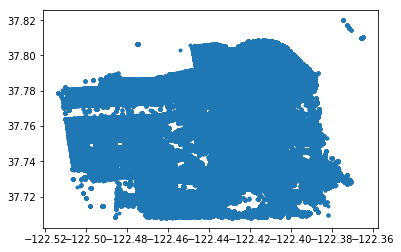

In [12]:
plt.plot(df["X"],df["Y"],'.')
plt.show()

In [13]:
shdf = df

#### Добавляю доп признаки из даты-времени

In [14]:
# в формат даты
shdf['Dates'] = pd.to_datetime(shdf['Dates'])

# Беру информацию из даты
shdf['year'] = shdf.Dates.apply(lambda x: x.timetuple().tm_year)
shdf['dayOfyear'] = shdf.Dates.apply(lambda x: x.timetuple().tm_yday)
shdf['hour'] = shdf.Dates.apply(lambda x: x.timetuple().tm_hour)
shdf['Day'] = shdf.Dates.apply(lambda x: x.timetuple().tm_mday)
shdf['Month'] = shdf.Dates.apply(lambda x: x.timetuple().tm_mon)
shdf['Hour'] = shdf.Dates.apply(lambda x: x.timetuple().tm_hour)
shdf['Weekday'] = shdf.Dates.apply(lambda x: x.timetuple().tm_wday)
shdf['Min'] = shdf.Dates.apply(lambda x: x.timetuple().tm_min)
shdf['TimeOfCrimeMinOfDay'] =  shdf.Dates.apply(lambda x: x.timetuple().tm_hour * 60 + x.timetuple().tm_min)
shdf['DateTime'] = shdf['Dates'].apply(lambda x: x.date())

weekend = {0:'0',1:'0',2:'0',3:'0',4:'1',5:'1',6:'1'}

shdf['Weekend'] = shdf['Weekday'].apply(lambda x: weekend[x])
shdf["Awake"]=shdf["Hour"].apply(lambda x: 1 if (x==0 or (x>=8 and x<=23)) else 0)

def get_season(x):
    summer=0
    fall=0
    winter=0
    spring=0
    if (x in [5, 6, 7]):
        summer=1
    if (x in [8, 9, 10]):
        fall=1
    if (x in [11, 0, 1]):
        winter=1
    if (x in [2, 3, 4]):
        spring=1
    return summer, fall, winter, spring


shdf["Summer"], shdf["Fall"], shdf["Winter"], shdf["Spring"]=zip(*shdf["Month"].apply(get_season))

In [15]:
shdf.head()

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y,year,...,Weekday,Min,TimeOfCrimeMinOfDay,DateTime,Weekend,Awake,Summer,Fall,Winter,Spring
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599,2015,...,2,53,1433,2015-05-13,0,1,1,0,0,0
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599,2015,...,2,53,1433,2015-05-13,0,1,1,0,0,0
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414,2015,...,2,33,1413,2015-05-13,0,1,1,0,0,0
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873,2015,...,2,30,1410,2015-05-13,0,1,1,0,0,0
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541,2015,...,2,30,1410,2015-05-13,0,1,1,0,0,0


#### Добавляю счетчики преступлений

In [16]:
shdf[['PdDistrict','DateTime']].groupby(['DateTime']).count().head()

,PdDistrict
DateTime,
2003-01-06,400
2003-01-07,418
2003-01-08,528
2003-01-09,417
2003-01-10,399


In [17]:
f = shdf[['PdDistrict','DateTime']].groupby(['DateTime']).count()
f['DateTime'] = f.index
f.columns = ['CountPerDay', 'DateTime']

f.head()

,CountPerDay,DateTime
DateTime,,
2003-01-06,400,2003-01-06
2003-01-07,418,2003-01-07
2003-01-08,528,2003-01-08
2003-01-09,417,2003-01-09
2003-01-10,399,2003-01-10


In [18]:
f.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2249 entries, 2003-01-06 to 2015-05-13
Data columns (total 2 columns):
CountPerDay    2249 non-null int64
DateTime       2249 non-null object
dtypes: int64(1), object(1)
memory usage: 52.7+ KB


In [19]:
# Объеденяю таблицы

shdf = shdf.merge(f, 'left', on='DateTime')

In [20]:
shdf.head()

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y,year,...,Min,TimeOfCrimeMinOfDay,DateTime,Weekend,Awake,Summer,Fall,Winter,Spring,CountPerDay
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599,2015,...,53,1433,2015-05-13,0,1,1,0,0,0,362
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599,2015,...,53,1433,2015-05-13,0,1,1,0,0,0,362
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414,2015,...,33,1413,2015-05-13,0,1,1,0,0,0,362
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873,2015,...,30,1410,2015-05-13,0,1,1,0,0,0,362
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541,2015,...,30,1410,2015-05-13,0,1,1,0,0,0,362


#### Добавляю фичу праздников страны (нерабочих)

Сделала в отдельном файле с отдельным кодом

In [21]:
holidaysDF = pd.read_csv('holidaysDF.csv',',',  dayfirst=True)
#df.columns
holidaysDF.head()

,holidays,DateTime
0,0,2015-05-13
1,0,2015-05-13
2,0,2015-05-13
3,0,2015-05-13
4,0,2015-05-13


In [22]:
# сколько праздничных записей
holidaysDF[holidaysDF.holidays == 1].shape

(28034, 2)

In [23]:
a_drop = holidaysDF.drop_duplicates()
a_drop

,holidays,DateTime
0,0,2015-05-13
362,0,2015-05-12
693,0,2015-05-11
1118,0,2015-05-03
1494,0,2015-05-02
1871,0,2015-05-01
2250,0,2015-04-30
2673,0,2015-04-29
3112,0,2015-04-28
3480,0,2015-04-27


In [24]:
holidaysDF.drop_duplicates().shape

(2249, 2)

In [25]:
holidaysDF.shape

(877982, 2)

In [26]:
# почему-то нормальное соединение сработало только так
#a_drop 
# в формат даты
a_drop['DateTime'] = pd.to_datetime(a_drop['DateTime'])

b = shdf
b['DateTime'] = pd.to_datetime(b['DateTime'])

/Users/aurinko/anaconda/envs/Python2_7_TensorFlow/lib/python2.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [27]:
print 'a_drop', a_drop.shape
print 'b', b.shape

a_drop (2249, 2)
b (877982, 26)


In [28]:
# Объеденяю таблицы

c1 = pd.merge(left = b, right = a_drop, how='left', on='DateTime')
shdf = c1
shdf.head()

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y,year,...,TimeOfCrimeMinOfDay,DateTime,Weekend,Awake,Summer,Fall,Winter,Spring,CountPerDay,holidays
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599,2015,...,1433,2015-05-13,0,1,1,0,0,0,362,0
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599,2015,...,1433,2015-05-13,0,1,1,0,0,0,362,0
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414,2015,...,1413,2015-05-13,0,1,1,0,0,0,362,0
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873,2015,...,1410,2015-05-13,0,1,1,0,0,0,362,0
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541,2015,...,1410,2015-05-13,0,1,1,0,0,0,362,0


In [29]:
#addresses=sorted(shdf["Address"].unique())

# Работа с Адресом

In [30]:
shdf.X = shdf.X.round(3)
shdf.Y = shdf.Y.round(3)

In [33]:
adr = sorted(shdf["Address"].unique())

In [ ]:
for i in adr:
    

In [36]:
shdf.groupby(["Address",'X',"Category"]).size()

Address                    X         Category              
0 Block of  HARRISON ST    -122.389  LARCENY/THEFT              1
0 Block of 10TH AV         -122.469  ASSAULT                    2
                                     FRAUD                      1
                                     OTHER OFFENSES             1
                                     ROBBERY                    1
0 Block of 10TH ST         -122.417  ASSAULT                    4
                                     BURGLARY                   1
                                     LARCENY/THEFT             10
                                     NON-CRIMINAL               3
                                     OTHER OFFENSES            11
                                     RECOVERED VEHICLE          1
                                     SECONDARY CODES            1
                                     SEX OFFENSES FORCIBLE      1
                                     SUSPICIOUS OCC             2
                

In [70]:
#sorted(shdf["Address"].unique())

In [71]:
#shdf.groupby(["Address","Category"]).size()

#### Добавляю таблицы погоды DATE', u'PRCP', u'SNOW', u'TMAX', u'TMIN'
сделала в отдельном файле

In [72]:
weather = pd.read_csv('weather.csv',',',  dayfirst=True)
#df.columns
weather.head()
weather.tail()

,DATE,PRCP,SNOW,TMAX,TMIN
4622,2015-08-28,0.0,1.0,87,64
4623,2015-08-29,0.0,1.0,72,64
4624,2015-08-30,0.0,1.0,71,62
4625,2015-08-31,0.0,1.0,75,60
4626,2015-09-01,0.0,1.0,70,61


In [73]:
weather.columns = [u'DateTime', u'PRCP', u'SNOW', u'TMAX', u'TMIN']

In [74]:
# почему-то нормальное соединение сработало только так
e = weather 
# в формат даты
e['DateTime'] = pd.to_datetime(e['DateTime'])

In [75]:
# Объеденяю таблицы
shdf = pd.merge(left = shdf, right = e, how='left', on='DateTime')
shdf.head()

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y,year,...,Summer,Fall,Winter,Spring,CountPerDay,holidays,PRCP,SNOW,TMAX,TMIN
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.426,37.775,2015,...,1,0,0,0,362,0,0.0,1.0,61,50
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.426,37.775,2015,...,1,0,0,0,362,0,0.0,1.0,61,50
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424,37.800,2015,...,1,0,0,0,362,0,0.0,1.0,61,50
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.427,37.801,2015,...,1,0,0,0,362,0,0.0,1.0,61,50
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.439,37.772,2015,...,1,0,0,0,362,0,0.0,1.0,61,50


In [76]:
shdf.SNOW.value_counts()

1.0    636306
0.0    241676
Name: SNOW, dtype: int64

#### Кодирую ниличие '/' в адресе

In [77]:
# Добавлю солонку 1 - если есть слеш в адресе - это значит - перекресток
shdf['Address'] = df['Address']
shdf['Corner'] = shdf['Address'].str.contains('/').convert_objects(convert_numeric=True)

/Users/aurinko/anaconda/envs/Python2_7_TensorFlow/lib/python2.7/site-packages/ipykernel_launcher.py:3: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  This is separate from the ipykernel package so we can avoid doing imports until


In [78]:
shdf['Corner'].value_counts()

0.0    617188
1.0    260727
Name: Corner, dtype: int64

### Создаею таблицу сохранить

In [79]:
shdf.to_csv('shdf_big1.csv', sep=',', index=False)

# ЗАГРУЖАЮ ТАБЛИЦУ - ТОЧКА ВОЗВРАТА

In [80]:
shdf.to_csv('shdf_big1.csv', sep=',', index=False)

In [81]:
# загрузка обратно, проверка
f = pd.read_csv('shdf_pregiven_ht.csv',',',  dayfirst=True)
#df.columns
f.head()

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y,year,...,dayOfyear_s,hour_s,Weekday_s,TimeOfCrimeMinOfDay_s,CountPerDay_s,TMAX_s,TMIN_s,PRCP_s,Xs,Ys
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599,2015,...,0.362637,1.0,0.333333,0.995828,0.555556,0.301887,0.4375,0.0,0.590099,0.595198
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599,2015,...,0.362637,1.0,0.333333,0.995828,0.555556,0.301887,0.4375,0.0,0.590099,0.595198
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414,2015,...,0.362637,1.0,0.333333,0.981919,0.555556,0.301887,0.4375,0.0,0.600379,0.825497
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873,2015,...,0.362637,1.0,0.333333,0.979833,0.555556,0.301887,0.4375,0.0,0.582677,0.829586
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541,2015,...,0.362637,1.0,0.333333,0.979833,0.555556,0.301887,0.4375,0.0,0.503713,0.567923


## Скалирую признаки

In [125]:
# X и Y скалирую

datascaler = MinMaxScaler(feature_range=(0, 1))
shdf['year_s'] = datascaler.fit_transform(shdf[['year']])
shdf['dayOfyear_s'] = datascaler.fit_transform(shdf[['dayOfyear']])
shdf['hour_s'] = datascaler.fit_transform(shdf[['hour']])
shdf['Weekday_s'] = datascaler.fit_transform(shdf[['Weekday']])

shdf['TimeOfCrimeMinOfDay_s'] = datascaler.fit_transform(shdf[['TimeOfCrimeMinOfDay']])
shdf['CountPerDay_s'] = datascaler.fit_transform(shdf[['CountPerDay']])

shdf['TMAX_s'] = datascaler.fit_transform(shdf[['TMAX']])
shdf['TMIN_s'] = datascaler.fit_transform(shdf[['TMIN']])
shdf['PRCP_s'] = datascaler.fit_transform(shdf[['PRCP']])

# X и Y скалирую

scaler = MinMaxScaler(feature_range=(0, 1))
shdf['Xs'] = scaler.fit_transform(shdf[['X']])
shdf['Ys'] = scaler.fit_transform(shdf[['Y']])

In [83]:
shdf.head()

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y,year,...,Fall,Winter,Spring,CountPerDay,holidays,PRCP,SNOW,TMAX,TMIN,Corner
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.426,37.775,2015,...,0,0,0,362,0,0.0,1.0,61,50,1.0
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.426,37.775,2015,...,0,0,0,362,0,0.0,1.0,61,50,1.0
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424,37.800,2015,...,0,0,0,362,0,0.0,1.0,61,50,1.0
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.427,37.801,2015,...,0,0,0,362,0,0.0,1.0,61,50,0.0
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.439,37.772,2015,...,0,0,0,362,0,0.0,1.0,61,50,0.0


In [82]:
#shdf.X.value_counts()

#### Кодирую категориальные признаки

In [91]:
Cdistr = pd.get_dummies(shdf.PdDistrict, prefix='Distr')

In [92]:
Cyear = pd.get_dummies(shdf.year, prefix='Y')

In [98]:
Cmon = pd.get_dummies(shdf.Month, prefix='M')

In [100]:
Cweek = pd.get_dummies(shdf.Weekday, prefix='W')

In [102]:
Chour = pd.get_dummies(shdf.hour, prefix='H')

In [111]:
Ccorner = pd.get_dummies(shdf.Corner, prefix='C',drop_first=True)

In [113]:
#holidays
Choli = pd.get_dummies(shdf.holidays, prefix='Hol',drop_first=True)

In [117]:
Csnow = pd.get_dummies(shdf.SNOW, prefix='Snow',drop_first=True)

In [123]:
Csummer = pd.get_dummies(shdf.Summer, prefix='Summer',drop_first=True)
Cfall = pd.get_dummies(shdf.Fall, prefix='Fall',drop_first=True)
Cwinter = pd.get_dummies(shdf.Winter, prefix='Winter',drop_first=True)
Cspring = pd.get_dummies(shdf.Spring, prefix='Spring',drop_first=True)

In [124]:
Cday = pd.get_dummies(shdf.Day, prefix='D')

# Создание готовых выборок нампай

In [135]:
from sklearn.model_selection import train_test_split

In [136]:
shdf.columns

Index([                u'Dates',              u'Category',
                    u'Descript',             u'DayOfWeek',
                  u'PdDistrict',            u'Resolution',
                     u'Address',                     u'X',
                           u'Y',                  u'year',
                   u'dayOfyear',                  u'hour',
                         u'Day',                 u'Month',
                        u'Hour',               u'Weekday',
                         u'Min',   u'TimeOfCrimeMinOfDay',
                    u'DateTime',               u'Weekend',
                       u'Awake',                u'Summer',
                        u'Fall',                u'Winter',
                      u'Spring',           u'CountPerDay',
                    u'holidays',                  u'PRCP',
                        u'SNOW',                  u'TMAX',
                        u'TMIN',                u'Corner',
                      u'year_s',           u'dayOfyear_s

### Cоздадим X

In [133]:
# соединяем таблицы обратно
X =np.hstack((np.array(shdf[['Xs', 'Ys', 'dayOfyear_s', 'TimeOfCrimeMinOfDay_s', 'Weekend', 'CountPerDay_s',
                             'PRCP', 'TMAX_s', 'TMIN_s', 'dayOfyear_s', 
                            ]]), Cdistr, Cweek, Cyear, Chour, Cmon, Csnow, Choli, Ccorner, Csummer, Cfall, Cwinter, Cspring, Cday))

In [134]:
X

array([[0.5906040268455399, 0.5982142857142776, 0.3626373626373627, ..., 0,
        0, 0],
       [0.5906040268455399, 0.5982142857142776, 0.3626373626373627, ..., 0,
        0, 0],
       [0.6040268456374633, 0.8214285714284983, 0.3626373626373627, ..., 0,
        0, 0],
       ..., 
       [0.7449664429528866, 0.6428571428571104, 0.013736263736263736, ...,
        0, 0, 0],
       [0.8255033557045408, 0.6517857142856656, 0.013736263736263736, ...,
        0, 0, 0],
       [0.798657718120694, 0.2678571428571104, 0.013736263736263736, ...,
        0, 0, 0]], dtype=object)

shdf[['Xs', 'Ys', 'dayOfyear_s', 'TimeOfCrimeMinOfDay_s', 'Weekend', 'CountPerDay_s',
                             'PRCP', 'TMAX_s', 'TMIN_s', 'dayOfyear_s']]

In [137]:
X

array([[0.5906040268455399, 0.5982142857142776, 0.3626373626373627, ..., 0,
        0, 0],
       [0.5906040268455399, 0.5982142857142776, 0.3626373626373627, ..., 0,
        0, 0],
       [0.6040268456374633, 0.8214285714284983, 0.3626373626373627, ..., 0,
        0, 0],
       ..., 
       [0.7449664429528866, 0.6428571428571104, 0.013736263736263736, ...,
        0, 0, 0],
       [0.8255033557045408, 0.6517857142856656, 0.013736263736263736, ...,
        0, 0, 0],
       [0.798657718120694, 0.2678571428571104, 0.013736263736263736, ...,
        0, 0, 0]], dtype=object)

In [138]:
np.save('X_full_only.npy', X)

In [51]:
# Y
#DUMMY
# train['species'] contains the actual species names. Before we can use it,
# we need to convert each species name into a digit. So, in this case there
# are three species, which have been coded as 0, 1, or ...
y_dummy = pd.get_dummies(shdf['Category'])

In [52]:
np.save('Y_dummy_full_digits.npy', y_dummy)

In [139]:
# Y
#DIGITS
# train['species'] contains the actual species names. Before we can use it,
# we need to convert each species name into a digit. So, in this case there
# are three species, which have been coded as 0, 1, or ...
y = pd.factorize(shdf['Category'])[0]

# View target
print y
print y.shape

[ 0  1  1 ...,  2  4 12]
(877982,)


In [140]:
np.save('Y_full_digits.npy', y)

In [141]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                  test_size = 0.3,
                                                  random_state=42)

# Сохранение готовых выборок нампай в файлы  

In [143]:
np.save('X_train.npy', X_train)
np.save('X_test.npy', X_test)
np.save('y_train.npy', y_train)
np.save('y_test.npy', y_test)

In [3]:
# загрузка обратно, проверка
f1 = np.load('X_train.npy')

In [145]:
f1

array([[0.6644295302012324, 0.7678571428571104, 0.4862637362637363, ..., 0,
        0, 0],
       [0.45637583892607836, 0.5535714285714448, 0.29670329670329676, ...,
        0, 0, 0],
       [0.45637583892607836, 0.5535714285714448, 0.5631868131868133, ...,
        0, 0, 0],
       ..., 
       [0.5838926174495782, 0.5446428571428328, 0.6071428571428572, ..., 0,
        0, 0],
       [0.859060402684463, 0.4107142857142776, 0.8434065934065935, ..., 0,
        0, 0],
       [0.7114093959730781, 0.678571428571388, 0.7472527472527474, ..., 0,
        1, 0]], dtype=object)

In [4]:
len(f1[0])

114

In [5]:
f1[0]

array([0.6644295302012324, 0.7678571428571104, 0.4862637362637363,
       0.3331015299026425, '0', 0.5941358024691358, 0.0,
       0.39622641509433965, 0.46875, 0.4862637362637363, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0], dtype=object)

In [6]:
f1[1]

array([0.45637583892607836, 0.5535714285714448, 0.29670329670329676,
       0.36787204450625866, '1', 0.5972222222222222, 0.01,
       0.2264150943396227, 0.40625, 0.29670329670329676, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0], dtype=object)